### **<span style="color:orange">Reference:</span>** https://huggingface.co/llava-hf/llava-v1.6-vicuna-13b-hf

In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration, BitsAndBytesConfig
import torch
from PIL import Image
import requests
from pprint import pprint

In [2]:
model_id = "llava-hf/llava-v1.6-vicuna-13b-hf"

**<span style="color:orange">Load the model</span>**

- **<span style="color:yellow">Quantized model: Requires near `21` GB of GPU memory with the configuration provided in the cell below.</span>**

In [3]:
processor = LlavaNextProcessor.from_pretrained(model_id)
quantized = True
if quantized:
        print("===============================================")
        print("Loading the quantized version of the model:")
        print("===============================================")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
        )
        model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, quantization_config=quantization_config, device_map="auto")
else:
        print("===============================================")
        print("Loading the full version of the model:")
        print("===============================================")
        model = LlavaNextForConditionalGeneration.from_pretrained(
        model_id, 
        # quantization_config=quantization_config,
        device_map="auto")

**<span style="color:orange">Model architecture</span>**

In [ ]:
print(model)

LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
            

**<span style="color:orange">Input: text and image</span>**

**<span style="color:yellow">Example 1</span>**

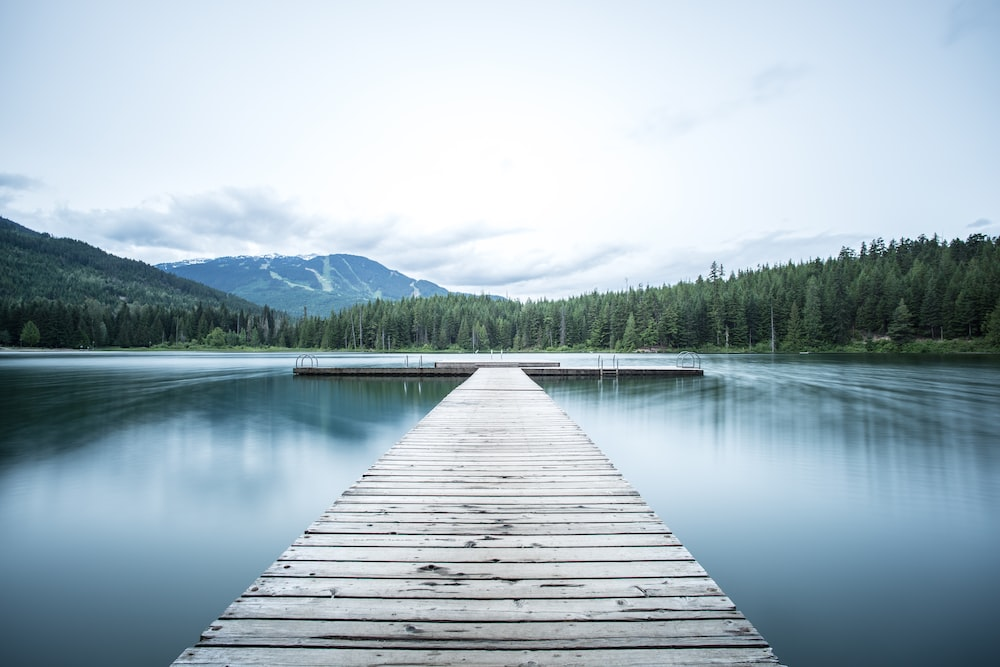

In [ ]:
url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True).raw)
image

In [ ]:
prompt = "What are the things I should be cautious about when I visit this place? What should I bring with me?"
max_output_token = 500
prompt = f"[INST] <image>\n{prompt} [/INST]"
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
output = model.generate(**inputs, max_new_tokens=max_output_token)
response = processor.decode(output[0], skip_special_tokens=True)
pprint(response)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


('[INST] \n'
 'What are the things I should be cautious about when I visit this place? What '
 'should I bring with me? [/INST]')


**<span style="color:yellow">Example 2</span>**

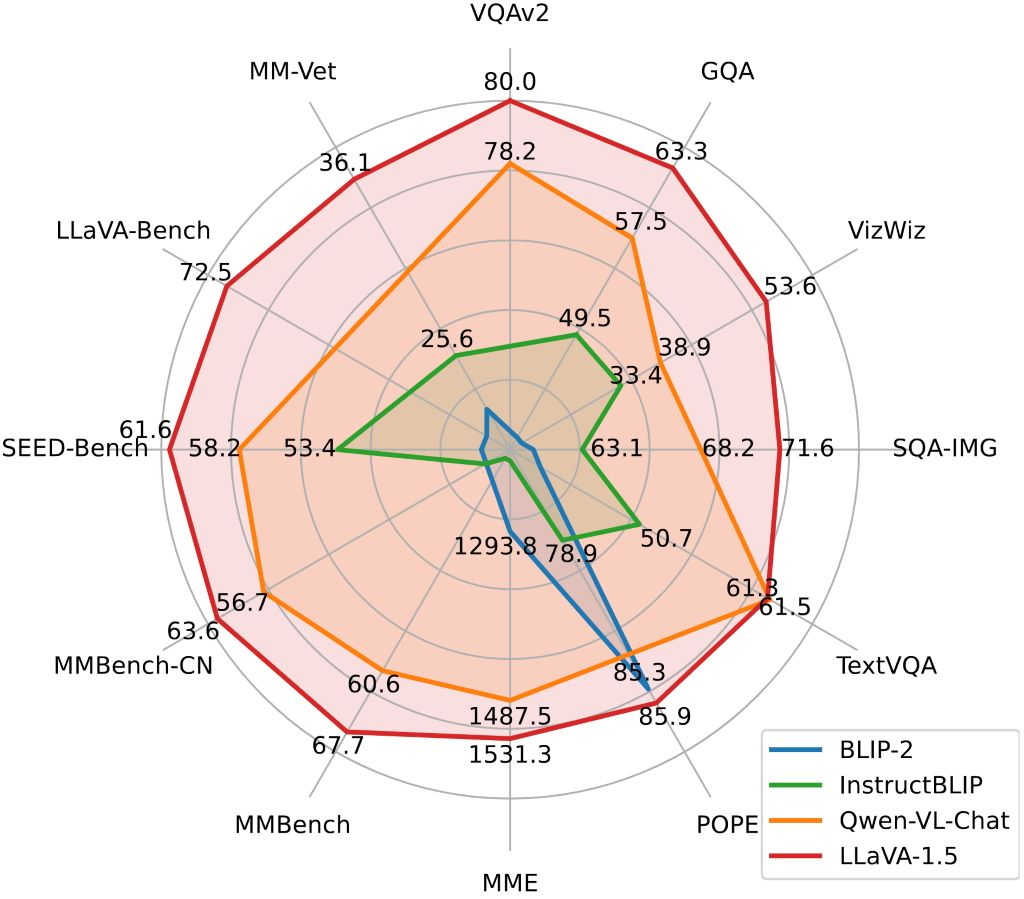

In [ ]:
# prepare image and text prompt, using the appropriate prompt template
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))

USER: 
What is shown in this image? ASSISTANT: The image appears to be a radar chart, also known as a spider chart or a star chart, which is a graphical method of displaying multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point.

In this particular chart, there are several axes labeled with different acronyms and values, which likely represent different metrics or variables being compared. The axes are labeled with acronym


### **<span style="color:orange">Test on cordv2</span>**

**<span style="color:yellow">Example 1</span>**

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

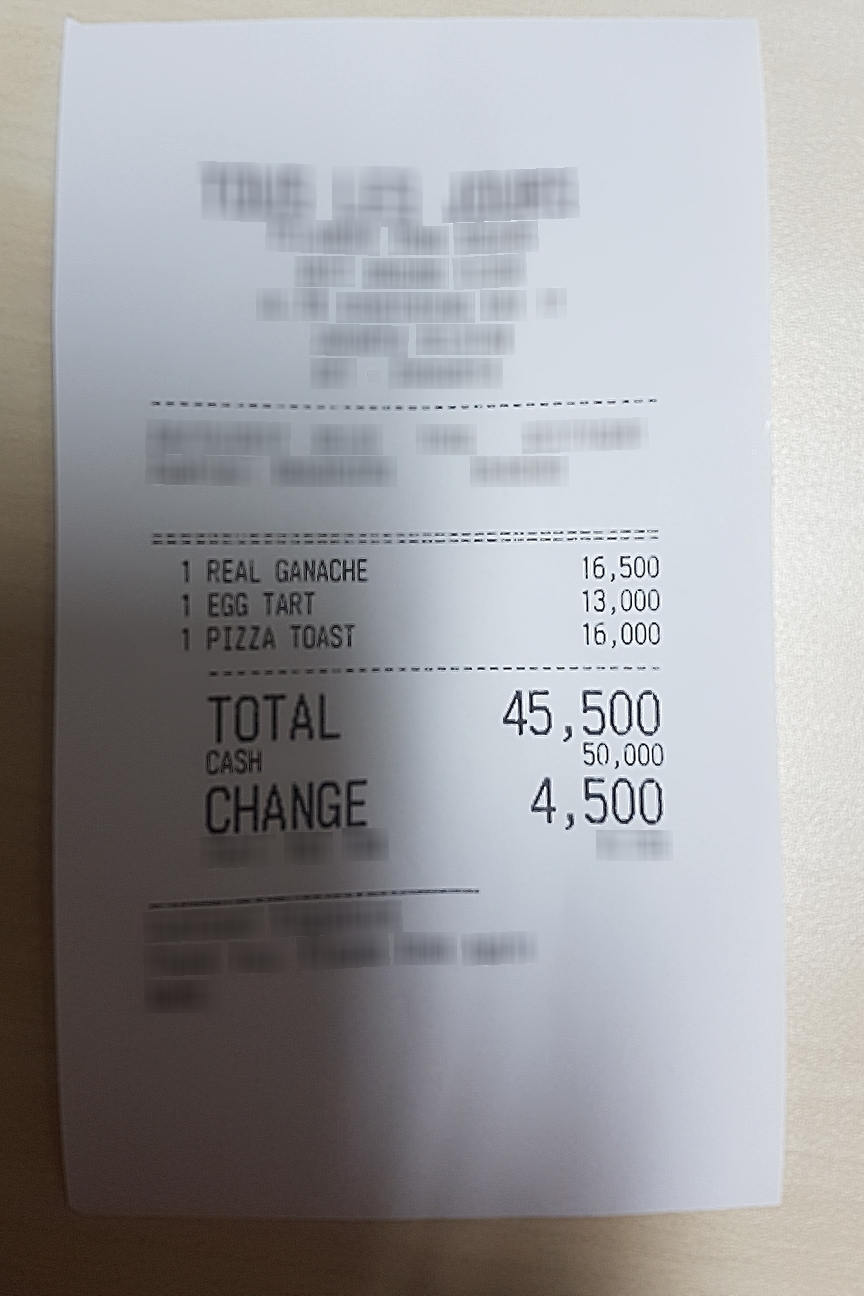

In [ ]:
image = dataset[0]["image"]
image

In [ ]:
# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))

USER: 
What is shown in this image? ASSISTANT: The image shows a receipt from a restaurant. The receipt lists the following items:

- 1 REAL GANACHE
- 1 EGG TART
- 1 PIZZA TOAST

The total cost of the items is 45,500, and the change given back is 4,500. The receipt also includes a barcode, which is typically used for returns or refunds. The date and


In [ ]:
# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "Extract JSON"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=500)

print(processor.decode(output[0], skip_special_tokens=True))

USER: 
Extract JSON ASSISTANT: The image you've provided appears to be a receipt. Here is the information extracted from the receipt in JSON format:

```json
{
  "REAL GANACHE": 1,
  "EGG TART": 1,
  "PIZZA TOAST": 1,
  "TOTAL": 45,
  "CASH": 4,
  "CHANGE": 500
}
```

Please note that the "REAL GANACHE" and "PIZZA TOAST" items are likely misspelled or incorrectly formatted, as "PIZZA" should be "PIZZA" (with two 'Z's) and "TOTAL" should be "TOTAL" (with a capital 'T'). The "CASH" and "CHANGE" values are also likely to be incorrect, as they seem to be the same amount, which is unusual for a receipt. The "REAL GANACHE" and "PIZZA TOAST" items are likely to be the same item, given the similar descriptions and the same quantity.


**<span style="color:yellow">Example 2</span>**

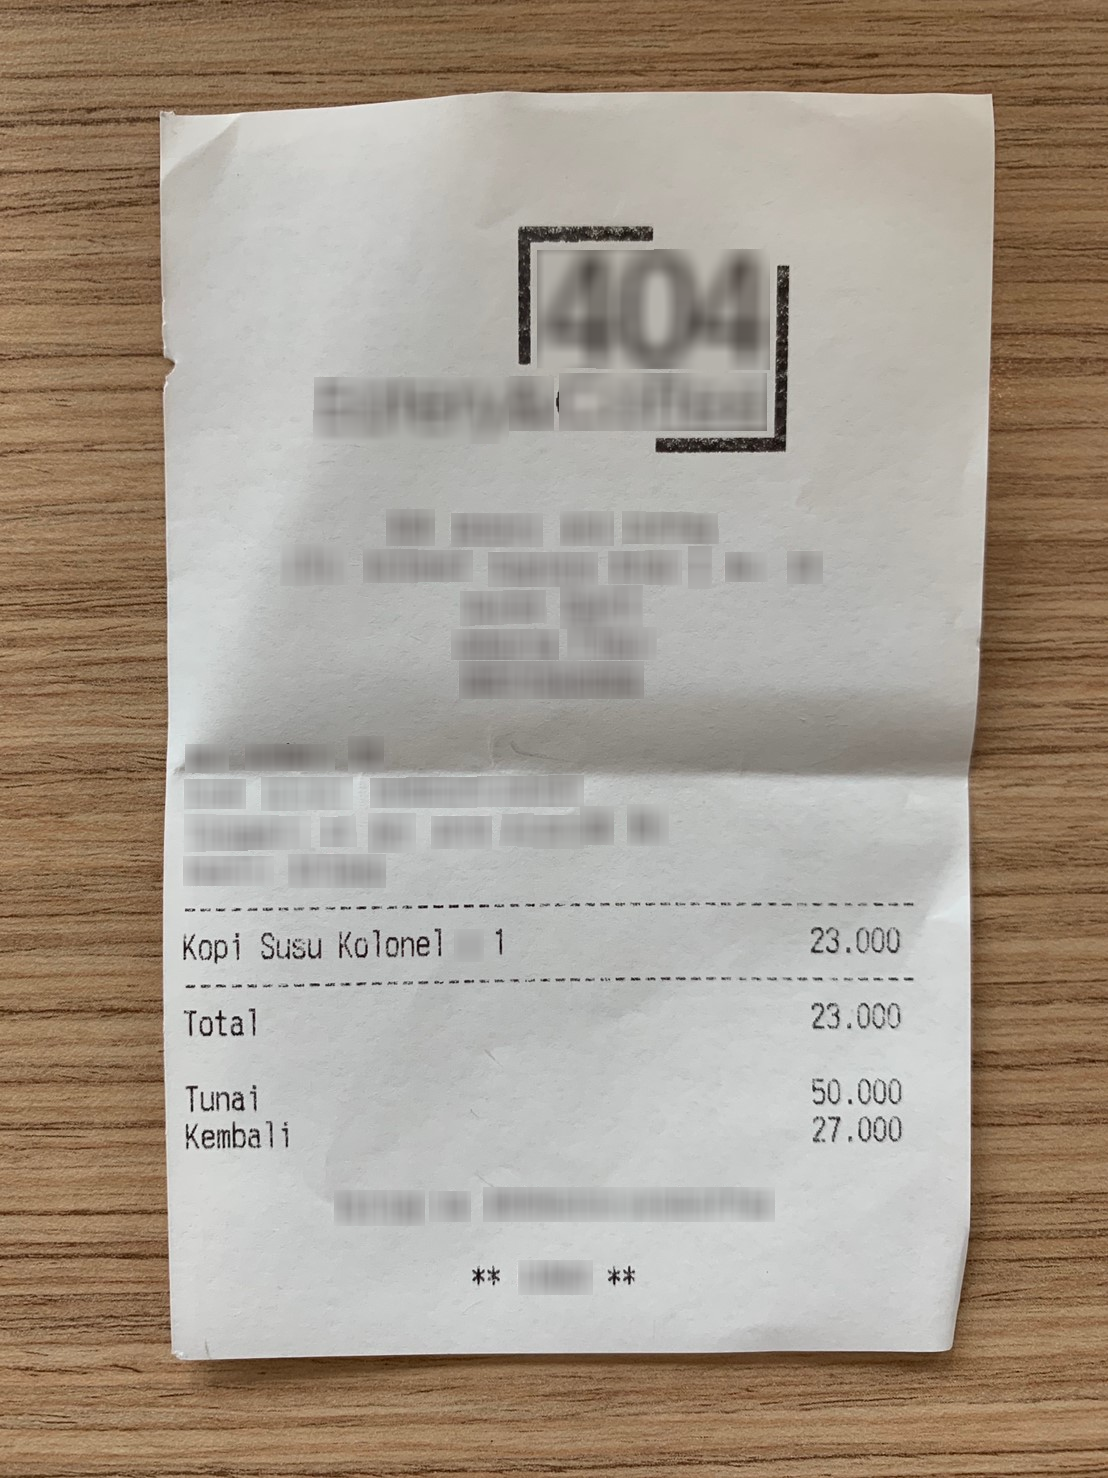

In [ ]:
image = dataset[1]["image"]
image

**<span style="color:pink">Pay attention to the output format</span>**

In [ ]:
# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "Extract JSON"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=500)

print(processor.decode(output[0], skip_special_tokens=False))

<s> USER: <image>
Extract JSON ASSISTANT: The image you've provided appears to be a receipt. Here is the extracted JSON data from the receipt:

```json
{
  "RECEIPT_ID": "404",
  "DATE": "202-09-23",
  "TIME": "12:00",
  "TOTAL": "23.000",
  "ITEMS": [
    {
      "ITEM": "Kopi Susu Kolonel 1",
      "QUANTITY": "1",
      "PRICE": "50.000",
      "TOTAL": "50.000"
    },
    {
      "ITEM": "Tuna Kembali",
      "QUANTITY": "1",
      "PRICE": "27.000",
      "TOTAL": "27.000"
    }
  ]
}
```

Please note that the JSON data is structured based on the visible fields on the receipt, and some fields like the store name, store address, and the customer's information are not visible in the image and are not included in the JSON output.</s>
